In [1]:
import os, sys; sys.path.append(os.path.abspath('../'))

# Crawl the data directory
import os

data_dir = r'..\data\baseline'

data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.mat')]
# loop over the files

import scipy.io

All_network_X = []
All_network_y = []

for f in data_files[:10]:
    data = scipy.io.loadmat(f)
    test_x = data['test_x']
    test_out = data['test_out']

    All_network_X.append(test_x)
    All_network_y.append(test_out)

import numpy as np

All_network_X = np.array(All_network_X)
All_network_y = np.array(All_network_y)

In [2]:
y_last_50_avg = All_network_y[:, :, :, -50:]
y_last_50_avg.shape
y_last_50_avg = np.average(y_last_50_avg, axis=3)
y_last_50_avg.shape
y_last_50_avg = y_last_50_avg.reshape(y_last_50_avg.shape[0], -1)
y_last_50_avg.shape

# for every value in y_last_50_avg, if it is greater than 0, set it to 1, else set it to -1
y_last_50_avg[y_last_50_avg > 0] = 1
y_last_50_avg[y_last_50_avg < 0] = -1

x_nuron_avg = np.average(All_network_X, axis=3)
x_nuron_avg.shape
x_nuron_avg = x_nuron_avg.reshape(10, 4*50, 300)
x_nuron_avg.shape
print(x_nuron_avg.shape, y_last_50_avg.shape)

(10, 200, 300) (10, 200)


In [9]:
X1 = x_nuron_avg[0]
X2 = x_nuron_avg[1]

y_pred1 = y_last_50_avg[0]
y_pred2 = y_last_50_avg[1]

print(X1.shape, X2.shape, y_pred1.shape, y_pred2.shape)

(200, 300) (200, 300) (200,) (200,)


In [10]:
from sklearn.cross_decomposition import CCA

In [11]:
# Concatenate the predicted labels with the neural data
X1_pred = np.concatenate([X1, y_pred1.reshape(-1, 1)], axis=1)
X2_pred = np.concatenate([X2, y_pred2.reshape(-1, 1)], axis=1)

print(X1_pred.shape, X2_pred.shape)

(200, 301) (200, 301)


In [12]:
# Perform CCA between the two sets of data
cca = CCA(n_components=1)
cca.fit(X1_pred, X2_pred)
canonical_corr = cca.score(X1_pred, X2_pred)
canonical_variates_1 = cca.transform(X1_pred)
canonical_variates_2 = cca.transform(X2_pred)

In [13]:
canonical_corr

0.0018138638340308717

In [16]:
canonical_variates_1.shape, canonical_variates_2.shape

((200, 1), (200, 1))

# Now all 10 metrix agaist each other

In [19]:
x_nuron_avg.shape, y_last_50_avg.shape

((10, 200, 300), (10, 200))

In [25]:
y_last_50_avg.reshape(10, -1, 1).shape

(10, 200, 1)

In [27]:
x_prep = np.concatenate([x_nuron_avg, y_last_50_avg.reshape(10, -1, 1)], axis=2)

In [28]:
x_prep.shape

(10, 200, 301)

In [64]:
import itertools
from sklearn.cross_decomposition import CCA

distmats_w2 = dict()


distmat_w2 = np.zeros((10, 10))
for i,j in itertools.combinations(range(10), 2): # Meaning: compute the distance between each pair of networks
    metric = CCA(n_components=1, max_iter=500, tol=1e-6)
    cca.fit(x_prep[i], x_prep[j])
    distmat_w2[i,j] = cca.score(x_prep[i], x_prep[j])
    # My score printing code
    print(f" Network {i+1} vs Network {j+1} -> score {distmat_w2[i,j]}") # Meaning: print the pair of networks

# dist matrix is symmetric
distmat_w2 += distmat_w2.T

 Network 1 vs Network 2 -> score 0.0018138638340308717
 Network 1 vs Network 3 -> score 0.0018525125650930376
 Network 1 vs Network 4 -> score 0.002153283325361993
 Network 1 vs Network 5 -> score 0.0017340419695693555
 Network 1 vs Network 6 -> score 0.0013372849715082883
 Network 1 vs Network 7 -> score 0.0013635925392757003
 Network 1 vs Network 8 -> score 0.0008989951686102515
 Network 1 vs Network 9 -> score 0.0011240754630458597
 Network 1 vs Network 10 -> score 0.0031609868675074116
 Network 2 vs Network 3 -> score 0.0009385629122025355
 Network 2 vs Network 4 -> score 0.0014253500434536995
 Network 2 vs Network 5 -> score 0.0010267708511964423
 Network 2 vs Network 6 -> score 0.0007702481175089846
 Network 2 vs Network 7 -> score 0.0007529006104725369
 Network 2 vs Network 8 -> score 0.0006642762628501542
 Network 2 vs Network 9 -> score 0.0006440613718407807
 Network 2 vs Network 10 -> score 0.0021559436219143486
 Network 3 vs Network 4 -> score 0.0024872201548402917
 Network 

In [66]:
# min-max normalization
distmat_w2_normalized = (distmat_w2 - distmat_w2.min()) / (distmat_w2.max() - distmat_w2.min())

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distmat(distmat, title = "Distance Metric", out_path = None):
    '''Plot a distance matrix
    New method uses Seaborn to create a heatmap
    '''

    # Set the x and y ticks to the labels
    number_of_networks = len(distmat[0])
    labels = [f"Network {i+1}" for i in range(number_of_networks)]

    # Create a new figure
    plt.figure()

    # Plot the heatmap using Seaborn
    ax = sns.heatmap(distmat, cmap='coolwarm', annot=False, fmt=".2f",
                     xticklabels=labels, yticklabels=labels, cbar_kws={})
    ax.set_title(title)

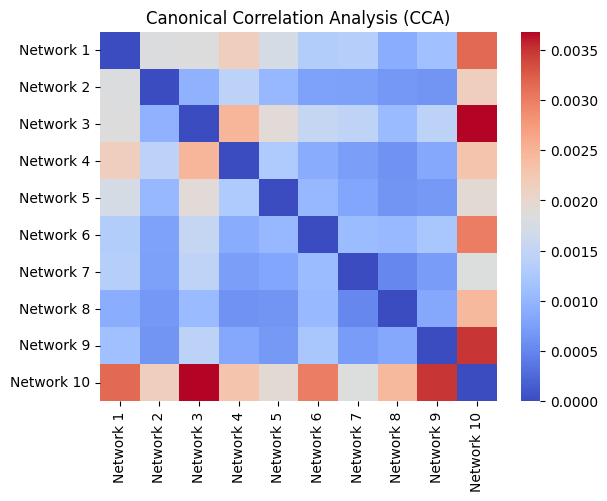

In [69]:
# for CCA(n_components=1, max_iter=500, tol=1e-6)
plot_distmat(distmat_w2, title=r"Canonical Correlation Analysis (CCA)")

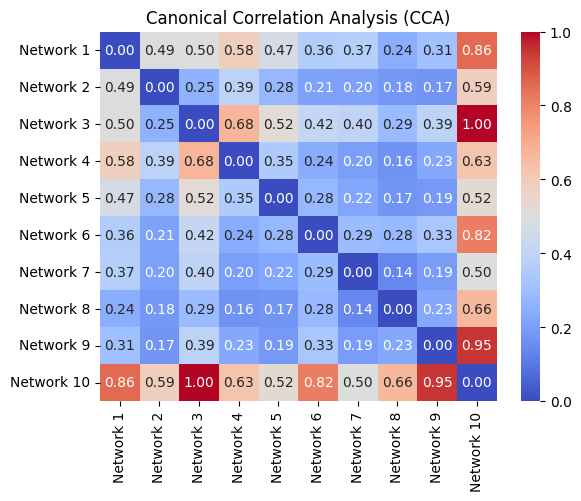

In [67]:
# for CCA(n_components=1, max_iter=500, tol=1e-6)
plot_distmat(distmat_w2_normalized, title=r"Canonical Correlation Analysis (CCA)")

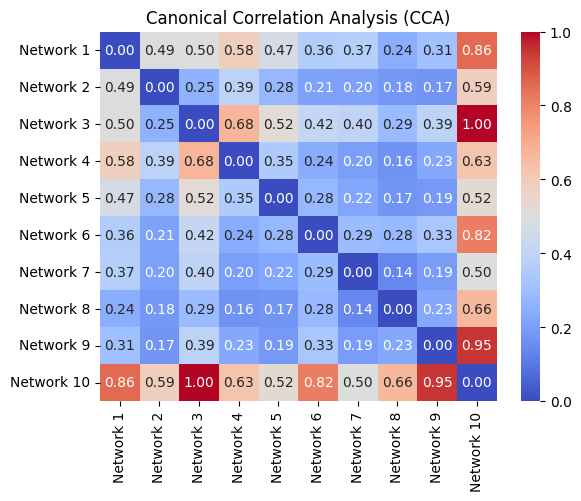

In [63]:
# basic without any hyperparameter in CCA
plot_distmat(distmat_w2_normalized, title=r"Canonical Correlation Analysis (CCA)")

In [57]:


# Fit supervised CCA between the two sets of data
scca = CCA(n_components=1, max_iter=500, tol=1e-6)
scca.fit(x_nuron_avg[0], x_nuron_avg[1], y_last_50_avg[0])


# Get the canonical variates and correlation coefficients
canonical_corr = scca.score(x_nuron_avg[0], x_nuron_avg[1], y_last_50_avg[0])

TypeError: fit() takes 3 positional arguments but 4 were given